### Binary Logistic Regression (dim = 8)

N = 1000

N_train = 50

N_test = 100

polynomials_max_deg = 1

$\tilde{n} = 100$

$f(\theta) = \sum_{i = 1}^d \theta_i$

$K=1$

In [6]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

## BLR data generation

In [2]:
d = 8
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))
def generate_data(p, n):
    X = np.empty((n,p))
    Y = np.empty(n)
    for i in range(n):
        prob = multivariate_normal.rvs(0,1,p)
        X[i, prob < 0] = -1
        X[i, prob >= 0] = +1
        X[i] = X[i]/np.linalg.norm(X[i])
        Y[i] = bernoulli.rvs(r(np.ones(p),X[i].reshape(p,1)))
    return X,Y.reshape((n,1))

In [3]:
np.random.seed(55)
X_reg, Y_reg = generate_data(d,100)

In [4]:
def sigma(X):
    n = X.shape[0]
    p = X.shape[1]
    S = np.zeros((p,p))
    for i in range(n):
        S = S + X[i].reshape((p,1)) @ X[i].reshape(1,p)
    return S 
    
def f_grad(theta, X, Y, Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p,1))
    for i in range(n):
        LOG = LOG + X[i].reshape((p,1)) / (1+np.exp(theta.T @ X[i].reshape((p,1))))
    F = X.T @ Y - LOG + lambda_c * Sigma @ theta
    return F

def MLE(X,Y,Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    eps = 1e-6
    mu = np.max(np.linalg.eigvals(Sigma))
    M = (lambda_c + 0.25*n) * mu
    theta_k =[]
    theta_k.append(np.ones((p,1)))
    theta_k.append(theta_k[0] - 1/(2*M) * f_grad(theta_k[0],X,Y,Sigma))
    i = 2
    while(np.linalg.norm(theta_k[i-1] - theta_k[i-2])**2 > eps**2):
        theta_k.append(theta_k[i-1] - 1/(2*M) * f_grad(theta_k[i-1],X,Y,Sigma))
        i = i+1
    return theta_k[-1]    

## MLE estimator of parameter vector

In [5]:
Sigma = sigma(X_reg)
MLE(X_reg,Y_reg,Sigma)

array([[-0.07992548],
       [-0.04057937],
       [-0.12193687],
       [-0.09644522],
       [-0.09996443],
       [-0.15080062],
       [-0.15221555],
       [ 0.06542268]])

### Parameters inicialization, ULA algorithm

In [6]:
def lmc_regression_without_precond(X,Y,Sigma, N):
    n = X.shape[0]
    p = X.shape[1]   
    h = 0.01
    K = 10000
    #-----------------------------------------------------
    vkh = np.empty((K + N,p,1), dtype=np.float64)
    ksi = multivariate_normal.rvs(np.zeros(p), np.eye(p),K+N).reshape(K+N, p,1)
    vkh[0] = (np.random.normal(0,1,p)).reshape(p,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1], X,Y,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

### Sample generation

In [7]:
np.random.seed(42)
X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 50000)

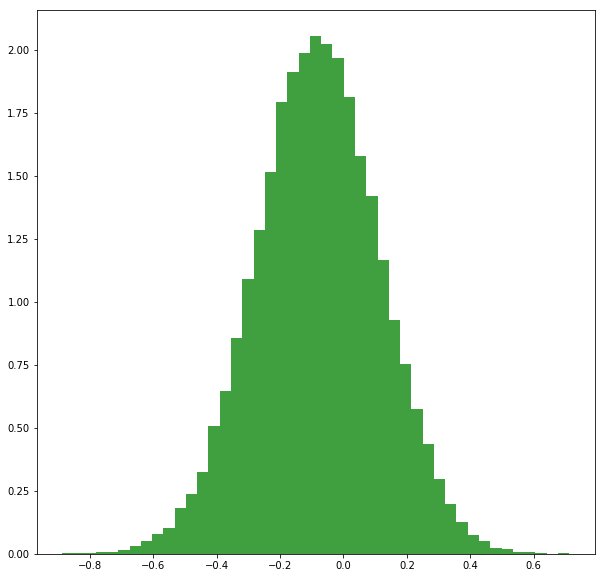

In [8]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,0].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

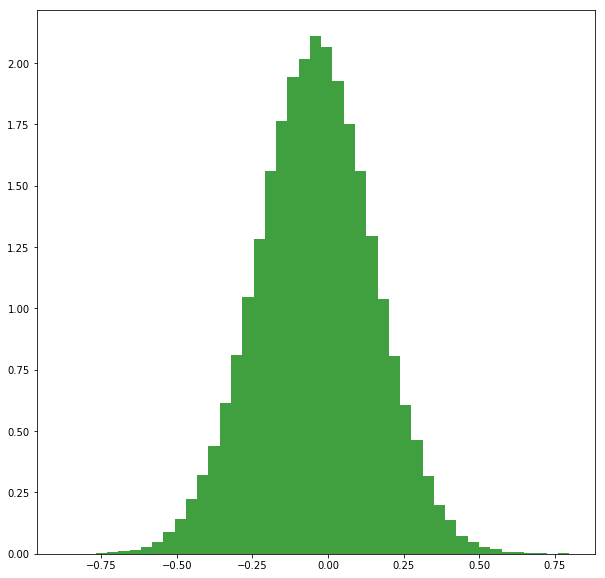

In [9]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

### Ordinary weighted estimator

In [4]:
def local_weighted_estimator(X):
    return X.sum(axis = 1).mean()

In [11]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.6826218572941264


### Generation of N_train independent paths

In [12]:
def generate_lmc_from_initial(x_initial,Sigma,N):
    h = 0.01
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1], X_reg,Y_reg,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,Sigma,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],Sigma,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [13]:
# np.random.seed(123)
# XX, ZZ = generate_paths(X,50,Sigma,1000)
XX = np.load('BLR_XX.npy')
ZZ = np.load('BLR_ZZ.npy')

np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],Sigma,1000)

### (normalized) Hermite polynomials

In [14]:
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

k_comb = np.zeros((d,d), dtype=np.int16)
for i in range(d):
    k_comb[i,i] = 1

### Fitting linear regression for $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right]$

In [15]:
def pol_ar_1d(x): #x.shape = (8,1)
    return np.array([1,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]])

def generate_X_reduced(XX, r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    X = np.empty((N_train * (N-r) ,d+1))
    all_points = XX[:, :N-r].reshape(-1,d)
    X[:,0] = np.ones(N_train * (N-r))
    for i in range(1,X.shape[1]):
        X[:,i] = all_points[:,i-1].squeeze()
    return X 

def generate_y_reduced(XX,r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    y = np.zeros(N_train * (N-r))
    y = XX[:, r:].sum(axis = 2).reshape(-1)
    return y

def G_pml_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,d+1))
    for r in tqdm(range(N)):
        X = generate_X_reduced(XX,r)
        y = generate_y_reduced(XX,r)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas

def G_pml_predict(x,pml,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[pml]
    return (x_pol @ beta)

In [40]:
Betas = G_pml_fit(XX)

100%|██████████| 1000/1000 [00:03<00:00, 275.09it/s]


In [41]:
np.save('BLR_XX.npy',XX)
np.save('BLR_ZZ.npy',ZZ)
np.save('BLR_Betas.npy',Betas)

In [16]:
Betas = np.load('BLR_Betas.npy')
XX = np.load('BLR_XX.npy')
ZZ = np.load('BLR_ZZ.npy')

In [17]:
degrees = np.zeros((d+1,d), dtype=np.int16)
for i in range(1,d+1):
    degrees[i,i-1] = 1

In [18]:
def a_plk(X,p,l,k_vec):
    h = 0.01
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1],X_reg,Y_reg,Sigma)
    Small_s = np.zeros(d)
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                        math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                    else:
                        pass
        S = S + Betas[p-l,ind] * Small_s.prod()
    return S

In [3]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

def M_bias(k_vec,X,Z,Betas_reduced,i):
    N = X.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<100):   #TRUNCATED
                s = a_plk(X,p,l,k_vec)* Hermite_val(k_vec,Z[l])
                S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas,i)for i in range(first, last))
    return np.array(M_results).reshape(-1)

In [72]:
X = XX[8]
Z = ZZ[8]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas,i),timeit.default_timer()-time_1))

P = -0.664417865431
M ([1, 0, 0, 0, 0, 0, 0, 0]) = [ 0.01025804] [Time:271.3939569690265]
M ([0, 1, 0, 0, 0, 0, 0, 0]) = [ 0.01300883] [Time:543.3090451799799]
M ([0, 0, 1, 0, 0, 0, 0, 0]) = [ 0.02379015] [Time:815.8226909210207]
M ([0, 0, 0, 1, 0, 0, 0, 0]) = [-0.02229531] [Time:1088.8282512089936]
M ([0, 0, 0, 0, 1, 0, 0, 0]) = [-0.01523163] [Time:1361.192909872043]
M ([0, 0, 0, 0, 0, 1, 0, 0]) = [ 0.01430963] [Time:1631.4895594669506]
M ([0, 0, 0, 0, 0, 0, 1, 0]) = [-0.00264024] [Time:1902.1201537919696]
M ([0, 0, 0, 0, 0, 0, 0, 1]) = [-0.00769495] [Time:2173.5519245290197]


### Check on test

In [77]:
np.random.seed(9651)
X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 50000)

XX_test, ZZ_test =  generate_paths(X,100,Sigma,1000)

P_test = estimator(XX_test)

np.save('BLR_XX_test', XX_test)
np.save('BLR_ZZ_test', ZZ_test)
# XX_test = np.load('BLR_XX_test.npy')
# ZZ_test = np.load('BLR_ZZ_test.npy')

100%|██████████| 100/100 [00:00<00:00, 22558.51it/s]


In [7]:
XX_test = np.load('BLR_XX_test.npy')
ZZ_test = np.load('BLR_ZZ_test.npy')
P_test = estimator(XX_test)

100%|██████████| 100/100 [00:00<00:00, 16340.60it/s]


In [8]:
# for i in range(d):
#     M_results[i] = estimator_bias(k_comb[i],XX_test,ZZ_test,Betas, 0, 100)
# np.save('BLR(8d)_M_results_test.npy',M_results)
M_results = np.load('BLR(8d)_M_results_test.npy')

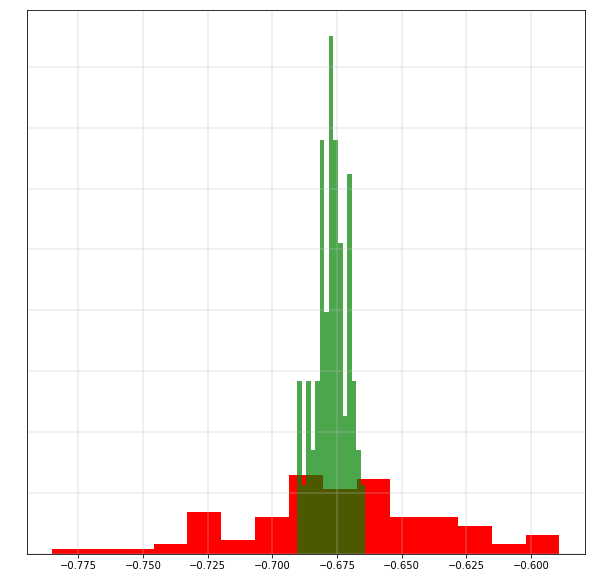

In [22]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1),15,facecolor='r', density=True,
                            alpha=1, label=r"$\pi$")

n, bins, patches = plt.hist((P_test-M_results.sum(axis=0)).reshape(-1,1),15, density=True, facecolor='g', 
                            alpha=0.7, label="Distribution of $\pi - M^1_N$")

#plt.legend(loc=2, prop={'size': 17})
plt.grid(which='major', axis='x', linewidth=0.45, linestyle='-', color='0.75')
plt.grid(which='major', axis='y', linewidth=0.45, linestyle='-', color='0.75')

plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
# plt.xlim(-0.5, 0.5)
plt.show()

In [23]:
print ('               Variance of Pi = ',P_test.var(ddof = 1))
for i in range(1,d+1):
    print ('Variance of new estimator (K=1)=',(P_test-M_results[:i].sum(axis = 0)).var(ddof = 1))

               Variance of Pi =  0.0014354733373463007
Variance of new estimator (K=1)= 0.0012134977283361882
Variance of new estimator (K=1)= 0.0009867485164345461
Variance of new estimator (K=1)= 0.0008274940606698479
Variance of new estimator (K=1)= 0.0006060672081742587
Variance of new estimator (K=1)= 0.0004921850471218123
Variance of new estimator (K=1)= 0.0003114719913244406
Variance of new estimator (K=1)= 0.0001764485527109148
Variance of new estimator (K=1)= 3.71237399801838e-05


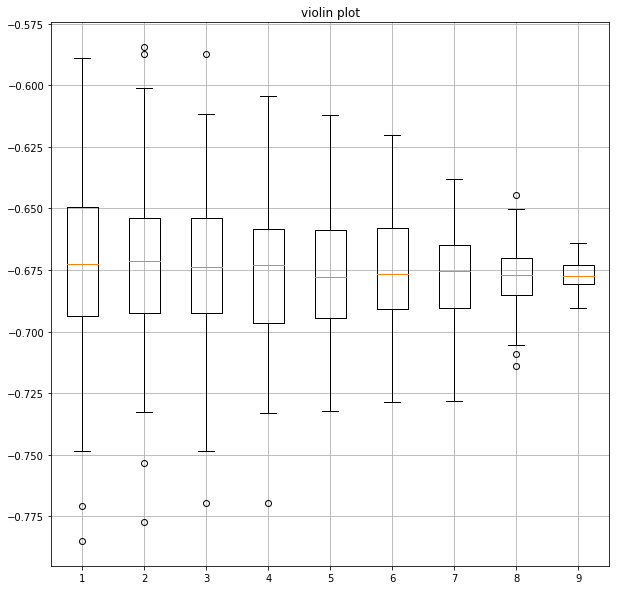

In [26]:
all_data = [P_test]
for i in range(1,d+1):
    all_data.append(P_test - M_results[:i].sum(axis = 0))
    
plt.figure(figsize=(10,10))
plt.boxplot(all_data)
plt.title('violin plot')
plt.grid()
plt.show()

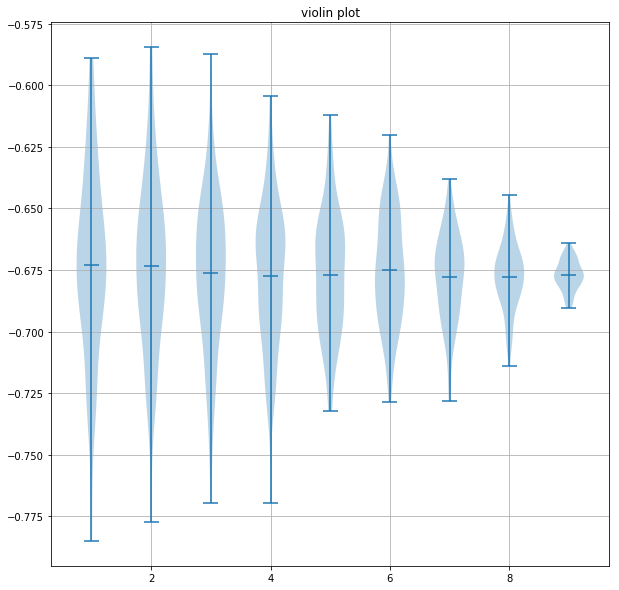

In [11]:
all_data = [P_test]
for i in range(1,d+1):
    all_data.append(P_test - M_results[:i].sum(axis = 0))
    
plt.figure(figsize=(10,10))
plt.violinplot(
        all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.grid()
plt.show()